In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from numpy.random import randn
from PIL import Image
from numpy import ndarray

In [3]:
import sys
sys.path.append('.')

In [4]:
from graph.graphs import Graph, ProductGraph
from graph.filters import GraphFilter, SpaceTimeGraphFilter
from models.smoothing import smooth_graph_signal

<IPython.core.display.Javascript object>


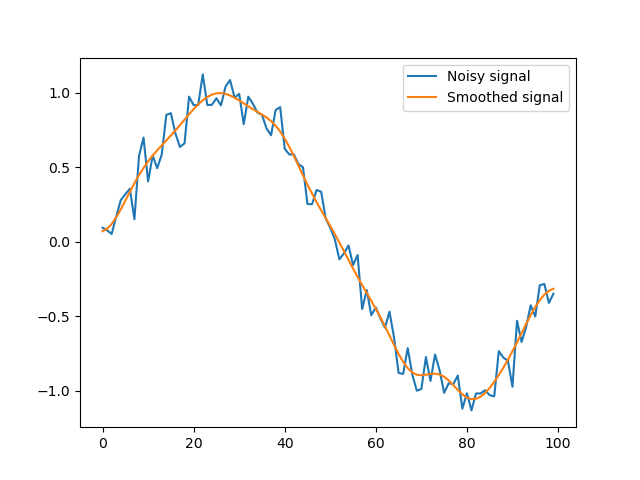

False
True
<class 'graph.graphs.Graph'>


interactive(children=(FloatSlider(value=-7.0, description='logγ', max=0.0, min=-10.0, step=0.05), Output()), _…

interactive(children=(FloatSlider(value=3.0, description='logβ', max=4.0, min=-1.0, step=0.05), Output()), _do…

<function __main__.update_beta(logβ=3)>

In [7]:
from ipywidgets import interact

fig, ax = plt.subplots()

N = 100
g1 = Graph.chain(N)

x = np.sin(np.linspace(0, 6, N)) + randn(N) / 10

gamma = 1
beta = 1
filt = GraphFilter.diffusion(beta=beta)

x_ = smooth_graph_signal(x, graph=g1, graph_filter=filt, gamma=gamma)

plt.plot(x, label='Noisy signal')
line, = ax.plot(x_, label='Smoothed signal')
plt.legend()

def update_gamma(logγ=-7):
    global gamma
    gamma = np.exp(logγ)
    x_ = smooth_graph_signal(x, graph=g1, graph_filter=filt, gamma=gamma)
    line.set_ydata(x_)
    fig.canvas.draw_idle()
    
    
def update_beta(logβ=3):
    global filt
    filt = GraphFilter.diffusion(beta=np.exp(logβ))
    x_ = smooth_graph_signal(x, graph=g1, graph_filter=filt, gamma=gamma)
    line.set_ydata(x_)
    fig.canvas.draw_idle()
    
    
interact(update_gamma, logγ=(-10, 0, 0.05))
interact(update_beta, logβ=(-1, 4, 0.05))

<IPython.core.display.Javascript object>


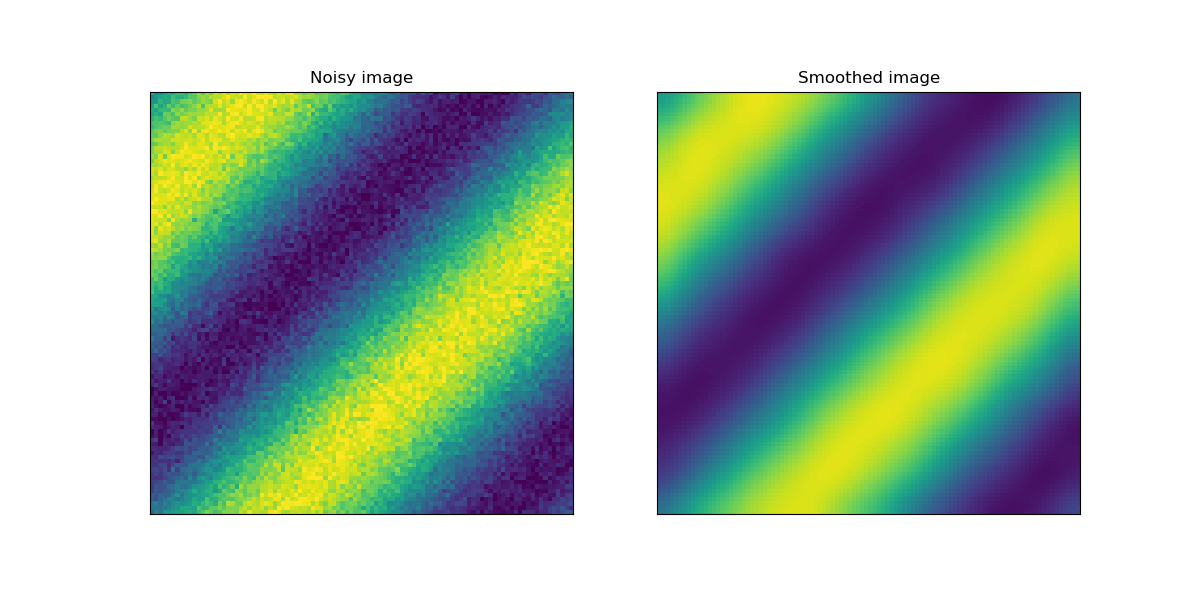

True
True
<class 'graph.graphs.ProductGraph'>


interactive(children=(FloatSlider(value=-5.0, description='logγ', max=1.0, min=-10.0, step=0.05), Output()), _…

interactive(children=(FloatSlider(value=0.0, description='logβ', max=5.0, min=-2.0, step=0.05), Output()), _do…

<function __main__.update_beta(logβ=0)>

In [8]:
from ipywidgets import interact

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[0].set_title('Noisy image')
axes[1].set_title('Smoothed image')

N1 = 100
N2 = 100

g2 = ProductGraph.lattice(N1, N2)

x = np.sin(sum(np.meshgrid(np.linspace(0, 6, N1), np.linspace(0, 6, N2)))) + randn(N1, N2) / 10

gamma = 1
beta = 1
filt = GraphFilter.diffusion(beta=beta)

x_ = smooth_graph_signal(x, graph=g2, graph_filter=filt, gamma=gamma)

axes[0].imshow(x, vmin=-1.1, vmax=1.1)
im = axes[1].imshow(x_, vmin=-1.1, vmax=1.1)

def update_gamma(logγ=-5):
    global gamma
    gamma = np.exp(logγ)
    x_ = smooth_graph_signal(x, graph=g2, graph_filter=filt, gamma=gamma)
    im.set(data=x_)
    fig.canvas.draw_idle()
    
    
def update_beta(logβ=0):
    global filt
    filt = GraphFilter.diffusion(beta=np.exp(logβ))
    x_ = smooth_graph_signal(x, graph=g2, graph_filter=filt, gamma=gamma)
    im.set(data=x_)
    fig.canvas.draw_idle()

    
interact(update_gamma, logγ=(-10, 1, 0.05))
interact(update_beta, logβ=(-2, 5, 0.05))

In [9]:
class ImageTransformPipeline: 
    
    def __init__(self, raw_data: ndarray):
        
        self.raw_data = raw_data.astype(float)
        self.channel_mean = self.raw_data.mean((0, 1))
        
    def transform(self):
        
        data = np.log(1 + self.raw_data)
        self.channel_mean = data.mean((0, 1))[None, None, :]
        data -= self.channel_mean
        self.channel_std = data.std((0, 1))[None, None, :]
        data /= self.channel_std
            
        return data
    
    def reverse_transform(self, new_data: ndarray):
        
        data = new_data.copy()
        data *= self.channel_std
        data += self.channel_mean
        
        return np.clip((np.exp(data) - 1), 0, 255).astype('uint8')
        

        

In [10]:
im = Image.open("data/images/pic1.jpg").resize((724 // 2, 856 // 2), Image.LANCZOS)
data = np.array(im).astype(float)
pipeline = ImageTransformPipeline(data)

<IPython.core.display.Javascript object>


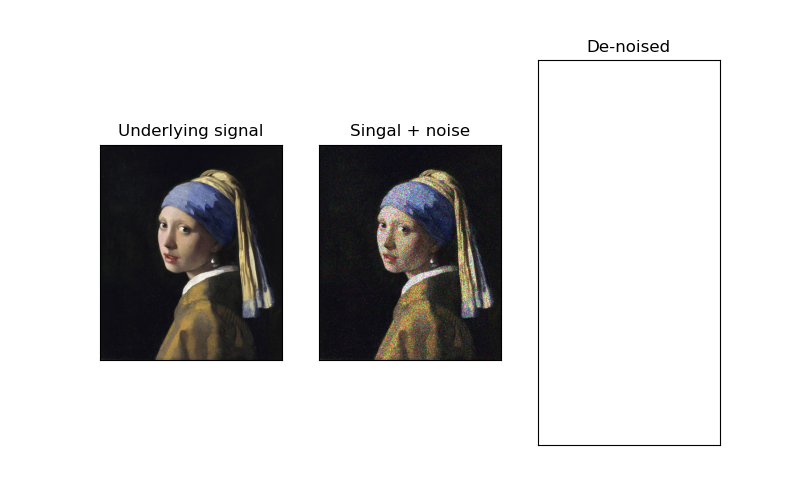

interactive(children=(FloatSlider(value=0.5, description='level', max=2.0, step=0.05), Output()), _dom_classes…

<function __main__.update_noise(level=0.5)>

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 5))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[0].set_title('Underlying signal')
axes[1].set_title('Singal + noise')
axes[2].set_title('De-noised')

data0 = pipeline.transform()
noise = np.random.randn(*data0.shape)
sig = 0.5

axes[0].imshow(pipeline.reverse_transform(data0))

im = axes[1].imshow(pipeline.reverse_transform(data0 + sig * noise))

graph = ProductGraph.lattice(*reversed(data0.shape))
filt = SpaceTimeGraphFilter.diffusion(betas=[1, 1, 1])

gamma = 1
data1 = smooth_graph_signal(data0 + sig * noise, graph=graph, graph_filter=filt, gamma=gamma)

def update_noise(level=0.5):
    global sig
    sig = level
    im.set(data=pipeline.reverse_transform(data0 + level * noise))
    fig.canvas.draw_idle()

interact(update_noise, level=(0, 2, 0.05))





True
True
<class 'graph.graphs.ProductGraph'>


array([[[-0.215, -0.218, -0.221],
        [-0.22 , -0.222, -0.225],
        [-0.227, -0.23 , -0.233],
        [-0.235, -0.237, -0.24 ],
        [-0.242, -0.245, -0.248],
        ...,
        [-0.194, -0.202, -0.21 ],
        [-0.171, -0.178, -0.185],
        [-0.148, -0.153, -0.158],
        [-0.129, -0.133, -0.136],
        [-0.119, -0.121, -0.123]],

       [[-0.218, -0.22 , -0.223],
        [-0.22 , -0.222, -0.225],
        [-0.223, -0.226, -0.229],
        [-0.227, -0.229, -0.232],
        [-0.232, -0.234, -0.237],
        ...,
        [-0.2  , -0.207, -0.215],
        [-0.18 , -0.187, -0.193],
        [-0.16 , -0.165, -0.171],
        [-0.144, -0.147, -0.151],
        [-0.134, -0.137, -0.139]],

       [[-0.231, -0.233, -0.236],
        [-0.23 , -0.232, -0.235],
        [-0.229, -0.231, -0.233],
        [-0.227, -0.229, -0.232],
        [-0.226, -0.228, -0.231],
        ...,
        [-0.212, -0.218, -0.225],
        [-0.196, -0.202, -0.208],
        [-0.18 , -0.184, -0.19 ],
     

In [ ]:
plt.figure()

plt.hist(np.log(1 + data[:, :, 2].flatten()), bins=100)

In [ ]:
(1 + data[:, :, 1].flatten()).min()